# Distributed quadratic programming

This is the script for the numerical experiment in the paper ...

## Install **pdra** package:
Ensure you have set up a git environment, and then run

In [4]:
%pip install "pdra[exp] @ git+https://github.com/rui-huang-opt/pdra.git"

  Cloning https://github.com/rui-huang-opt/pdra.git to /tmp/pip-install-xyxiyfwv/pdra_b16650cb84bf4b3285d6cb12bc4bbcec
  Running command git clone --filter=blob:none --quiet https://github.com/rui-huang-opt/pdra.git /tmp/pip-install-xyxiyfwv/pdra_b16650cb84bf4b3285d6cb12bc4bbcec
  Resolved https://github.com/rui-huang-opt/pdra.git to commit 0a3fe5a9edcaeba2d93064fde434045f8b9af845
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rui-huang-opt/gossip.git to /tmp/pip-install-xyxiyfwv/gossip_cc5fa66bc52f4e8c97e6097e13fc8b99
  Running command git clone --filter=blob:none --quiet https://github.com/rui-huang-opt/gossip.git /tmp/pip-install-xyxiyfwv/gossip_cc5fa66bc52f4e8c97e6097e13fc8b99
  Resolved https://github.com/rui-huang-opt/gossip.git to commit cc26e514d3b2c0e0a710e449d39455825077cba2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done

## Set some important directories path (**compulsory**):

In [24]:
import os

script_dir = os.getcwd()
data_dir = os.path.join(script_dir, "data", "dqp")
figure_dir = os.path.join(script_dir, "figures", "dqp")
results_dir = os.path.join(script_dir, "results", "dqp")

## Communication topology (**compulsory**):

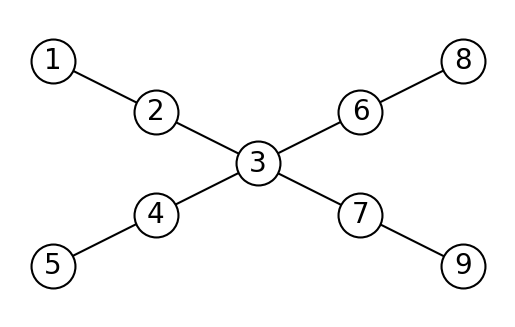

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

node_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
edge_pairs = [
    ("1", "2"),
    ("2", "3"),
    ("3", "4"),
    ("3", "6"),
    ("3", "7"),
    ("4", "5"),
    ("6", "8"),
    ("7", "9"),
]

plt.rcdefaults()

graph = nx.Graph()
graph.add_nodes_from(node_names)
graph.add_edges_from(edge_pairs)

fig1, ax1 = plt.subplots()

ax1.set_aspect(1)
ax1.set_ylim(-1.5, 1.5)

nx_options = {
    "with_labels": True,
    "font_size": 20,
    "node_color": "white",
    "node_size": 1000,
    "edgecolors": "black",
    "linewidths": 1.5,
    "width": 1.5,
    "pos": {
        "1": [-2.0, 1.0],
        "2": [-1.0, 0.5],
        "3": [0.0, 0.0],
        "4": [-1.0, -0.5],
        "5": [-2.0, -1.0],
        "6": [1.0, 0.5],
        "7": [1.0, -0.5],
        "8": [2.0, 1.0],
        "9": [2.0, -1.0],
    },
}

nx.draw(graph, ax=ax1, **nx_options)

plt.show()

## Problem formulation:
$$
\begin{split}
    \min_{\boldsymbol{x}_{1}, \ldots, \boldsymbol{x}_{9}} \quad &\sum_{i \in \mathcal{I}}\left( \frac{1}{2}\boldsymbol{x}_{i}^{\top}Q_{i}\boldsymbol{x}_{i} + \boldsymbol{g}_{i}^{\top}\boldsymbol{x}_{i} \right)\\
    \text{s.t.} \quad
    &\begin{cases}
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 1}^{\top}\boldsymbol{x}_{i} \leq b_{1}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 2}^{\top}\boldsymbol{x}_{i} \leq b_{2}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 3}^{\top}\boldsymbol{x}_{i} \leq b_{3}(D)
    \end{cases}
\end{split}
$$

### Load data (**compulsory**):

In [ ]:
import numpy as np
from typing import Dict
from numpy.typing import NDArray

Q: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "Q.npz"))
g: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "g.npz"))
A: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "A.npz"))

D: NDArray[np.float64] = np.load(os.path.join(data_dir, "D.npy"))

proportion_of_1 = D[np.where(D == 1)].size / 1000
proportion_of_2 = D[np.where(D == 2)].size / 1000
proportion_of_3 = D[np.where(D == 3)].size / 1000

b: NDArray[np.float64] = np.array([proportion_of_1, proportion_of_2, proportion_of_3])

### Run centralized optimization (**compulsory**):

In [16]:
import cvxpy as cp

x: dict[str, cp.Variable] = {i: cp.Variable(A[i].shape[1]) for i in node_names}

cost = cp.sum([x[i] @ Q[i] @ x[i] / 2 + g[i] @ x[i] for i in node_names])
constraints: list[cp.Constraint] = [
    sum([A[i] @ x[i] for i in node_names], start=cp.Constant(0)) <= b
]

problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve(solver="OSQP")

opt_val: np.float64 = problem.value  # type: ignore

print(f"Centralized optimal value: {opt_val}")

Centralized optimal value: -60.92641675724471


### Run sensitivity analysis:

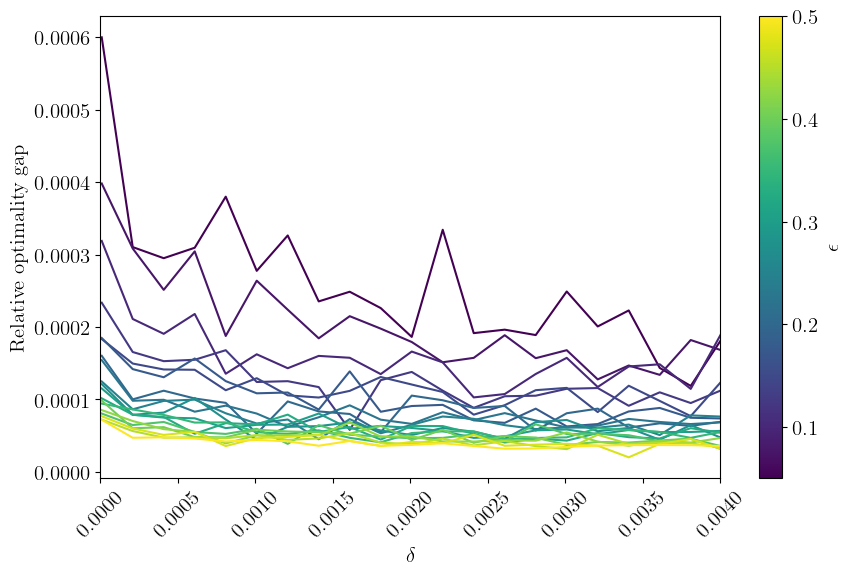

In [ ]:
from pdra import TruncatedLaplace

x: dict[str, cp.Variable] = {i: cp.Variable(A[i].shape[1]) for i in node_names}
b_bar = cp.Parameter(b.size)

cost = cp.sum([x[i] @ Q[i] @ x[i] / 2 + g[i] @ x[i] for i in node_names])
constraints: list[cp.Constraint] = [
    sum([A[i] @ x[i] for i in node_names], start=cp.Constant(0)) <= b_bar
]

problem = cp.Problem(cp.Minimize(cost), constraints)

epsilons = np.arange(0.05, 0.525, 0.025)
deltas = np.arange(1e-5, 0.0042 + 1e-5, 0.0002)
Delta = 0.002

n_eps = epsilons.size
n_del = deltas.size
n_samples = n_eps * n_del
run_times = 50

Eps, Del = np.meshgrid(epsilons, deltas, indexing="ij")
param_pairs = np.dstack((Eps, Del)).reshape(-1, 2)

opt_perturb = np.zeros((n_samples, run_times))

for i in range(n_samples):
    epsilon, delta = param_pairs[i]
    s = (Delta / epsilon) * np.log(b.size * (np.exp(epsilon) - 1) / delta + 1)
    tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)

    perturbation = -s * np.ones(b.size) + tl.sample(b.size)
    b_bar.value = b + perturbation

    for j in range(run_times):
        problem.solve(solver="OSQP")
        opt_perturb[i, j] = problem.value

rel_opt_gap: NDArray[np.float64] = np.abs(
    (np.mean(opt_perturb, axis=1) - opt_val) / opt_val
)
rel_opt_gap = rel_opt_gap.reshape(n_eps, n_del)

fig2, ax2 = plt.subplots(figsize=(10, 6))

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors

cmap = mpl.colormaps["viridis"]
norm = mcolors.Normalize(vmin=epsilons.min(), vmax=epsilons.max())

for i in range(n_eps):
    color = cmap(norm(epsilons[i]))
    ax2.plot(
        deltas,
        rel_opt_gap[i, :],
        label=f"$\\epsilon = {epsilons[i]:.2f}$",
        color=color,
    )

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig2.colorbar(sm, ax=ax2, orientation="vertical")
cbar.set_label("$\\epsilon$")
ax2.set_xlim(0.0, 0.004)
ax2.tick_params(axis="x", rotation=45)
ax2.set_xlabel("$\\delta$")
ax2.set_ylabel("Relative optimality gap")

plt.show()

### Run distributed optimization:
#### Algorithm:

In [ ]:
algorithm = "core"  # "core" or "rsdd"

#### Resource perturbation:

In [ ]:
epsilon = 0.5
delta = 0.005
Delta = 0.002

np.random.seed(0)

perturbation: NDArray[np.float64]

if algorithm == "core":
    from pdra import TruncatedLaplace

    s = (Delta / epsilon) * np.log(b.size * (np.exp(epsilon) - 1) / delta + 1)
    tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)
    perturbation = -s * np.ones(b.size) + tl.sample(b.size)

elif algorithm == "rsdd":
    perturbation = np.random.laplace(0, Delta / epsilon, b.size)

b_bar = b + perturbation

#### Resource allocation:

In [31]:
if __name__ == "__main__":
    from functools import partial
    from pdra import Node
    from gossip import create_sync_network

    node_params = {
        "core": {
            "max_iter": 2000,
            "step_size": 3.0,
            "method": "AGM",
            "solver": "OSQP",
            "results_prefix": os.path.join(results_dir, "core"),
        },
        "rsdd": {
            "max_iter": 2000,
            "step_size": 300.0,
            "solver": "OSQP",
            "results_prefix": os.path.join(results_dir, "rsdd"),
            "decay_rate": 0.9,
            "penalty_factor": 1e3,
        },
    }

    gossip_network = create_sync_network(node_names, edge_pairs)

    def f(x: cp.Variable, index: str) -> cp.Expression:
        return x @ Q[index] @ x / 2 + g[index] @ x

    nodes = [
        Node.create(
            algorithm,
            gossip_network[i],
            partial(f, index=i),
            A[i],
            **node_params[algorithm],
        )
        for i in node_names
    ]

    nodes[0].set_resource(b_bar)

    for node in nodes:
        node.start()

    for node in nodes:
        node.join()

## Set up latex options for matplotlib (**compulsory**):

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = "\\usepackage{amsmath}"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 15

## Results plot:
- Load results:

In [32]:
iterations = np.arange(1, node_params["core"]["max_iter"] + 1)

results = {
    "core": {
        i: np.load(node_params["core"]["results_prefix"] + f"/node_{i}.npz")
        for i in node_names
    },
    "rsdd": {
        i: np.load(node_params["rsdd"]["results_prefix"] + f"/node_{i}.npz")
        for i in node_names
    },
}

- Error evolution:

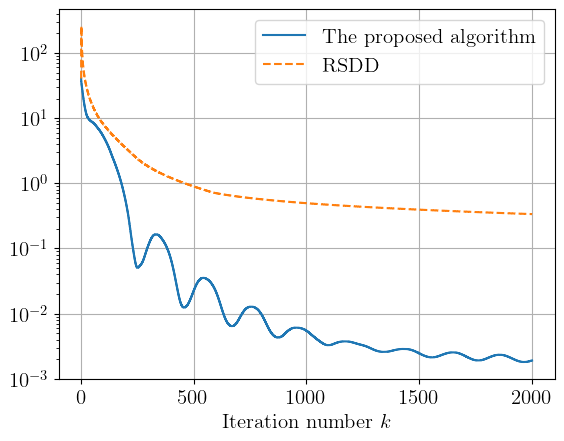

In [ ]:
fig3, ax3 = plt.subplots()

err_series = {
    "core": sum([results["core"][i]["f_i_series"] for i in node_names]) - opt_val,
    "rsdd": sum([results["rsdd"][i]["f_i_series"] for i in node_names]) - opt_val,
}

ax3.step(
    iterations,
    err_series["core"],
    label="The proposed algorithm",
    color="tab:blue",
    linestyle="-",
)

ax3.step(
    iterations,
    err_series["rsdd"],
    label="RSDD",
    color="tab:orange",
    linestyle="--",
)

ax3.set_xlabel("Iteration number $k$")
ax3.set_yscale("log")
ax3.legend()
ax3.grid()

plt.show()

- Constraints violation:

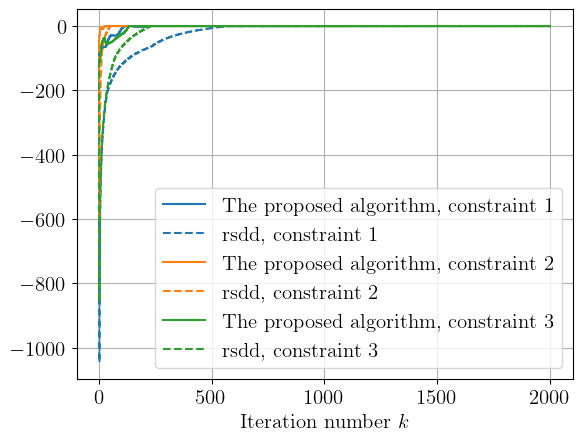

In [34]:
fig4, ax4 = plt.subplots()

colors = {
    "1": "tab:blue",
    "2": "tab:orange",
    "3": "tab:green",
    "4": "tab:red",
    "5": "tab:purple",
    "6": "tab:brown",
    "7": "tab:pink",
    "8": "tab:gray",
    "9": "tab:olive",
}

constraint_values = {
    "core": sum([A[i] @ results["core"][i]["x_i_series"] for i in node_names])
    - b[:, np.newaxis],
    "rsdd": sum([A[i] @ results["rsdd"][i]["x_i_series"] for i in node_names])
    - b[:, np.newaxis],
}

for i in range(constraint_values["core"].shape[0]):
    ax4.step(
        iterations,
        constraint_values["core"][i],
        linestyle="-",
        color=colors[str(i + 1)],
        label=f"The proposed algorithm, constraint {i + 1}",
    )
    ax4.step(
        iterations,
        constraint_values["rsdd"][i],
        linestyle="--",
        color=colors[str(i + 1)],
        label=f"rsdd, constraint {i + 1}",
    )

ax4.set_xlabel("Iteration number $k$")
ax4.legend()
ax4.grid()

plt.show()

- Computation time:

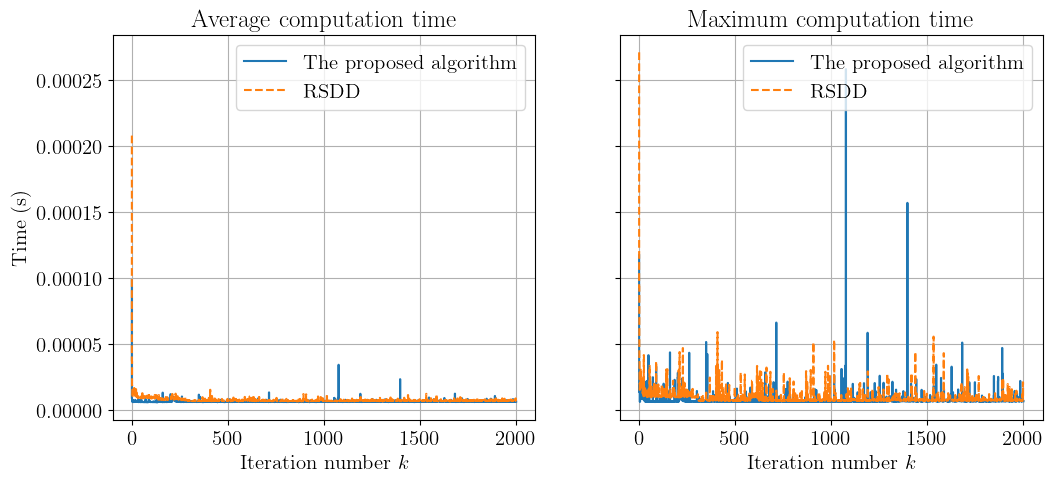

In [35]:
fig5, ax5 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

from matplotlib.axes import Axes

ax5_0: Axes = ax5[0]
ax5_1: Axes = ax5[1]

computation_times = {
    "core": np.vstack([results["core"][i]["computation_time"] for i in node_names]),
    "rsdd": np.vstack([results["rsdd"][i]["computation_time"] for i in node_names]),
}

avg_times = {
    "core": np.mean(computation_times["core"], axis=0),
    "rsdd": np.mean(computation_times["rsdd"], axis=0),
}

max_times = {
    "core": np.max(computation_times["core"], axis=0),
    "rsdd": np.max(computation_times["rsdd"], axis=0),
}

# Average computation time (left)
ax5_0.step(
    iterations,
    avg_times["core"],
    label="The proposed algorithm",
    color="tab:blue",
    linestyle="-",
)
ax5_0.step(
    iterations,
    avg_times["rsdd"],
    label="RSDD",
    color="tab:orange",
    linestyle="--",
)
ax5_0.set_xlabel("Iteration number $k$")
ax5_0.set_ylabel("Time (s)")
ax5_0.set_title("Average computation time")
ax5_0.legend()
ax5_0.grid()

# Maximum computation time (right)
ax5_1.step(
    iterations,
    max_times["core"],
    label="The proposed algorithm",
    color="tab:blue",
    linestyle="-",
)
ax5_1.step(
    iterations,
    max_times["rsdd"],
    label="RSDD",
    color="tab:orange",
    linestyle="--",
)
ax5_1.set_xlabel("Iteration number $k$")
ax5_1.set_title("Maximum computation time")
ax5_1.legend()
ax5_1.grid()

plt.show()

## Save the figures:

In [ ]:
fig1.savefig(os.path.join(figure_dir, "fig_1.pdf"), format="pdf", bbox_inches="tight")
fig2.savefig(os.path.join(figure_dir, "fig_2.pdf"), format="pdf", bbox_inches="tight")
fig3.savefig(os.path.join(figure_dir, "fig_3.pdf"), format="pdf", bbox_inches="tight")
fig4.savefig(os.path.join(figure_dir, "fig_4.pdf"), format="pdf", bbox_inches="tight")
fig5.savefig(os.path.join(figure_dir, "fig_5.pdf"), format="pdf", bbox_inches="tight")